In [1]:
from tensorflow.keras.datasets import mnist
import sys

from tqdm import tqdm
import torchvision
import math
from torch import optim
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader

In [2]:
device = 'cuda'

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[y_train == 1]

X_train = torch.Tensor(X_train).to(torch.int32).unsqueeze(1)
X_test = torch.Tensor(X_test).to(torch.int32).unsqueeze(1)

train_loader = DataLoader(X_train, batch_size=256, shuffle=False)
val_loader = DataLoader(X_test, batch_size=256, shuffle=False)

In [4]:
class ImageFlow(nn.Module):
    def __init__(self, flows):
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.prior = torch.distributions.normal.Normal(loc=0, scale=1)

    def forward(self, x):
        return self._get_likelihood(x)

    def encode(self, x):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = x, torch.zeros(x.shape[0], device=device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, x, return_ll=False):
        z, ldj = self.encode(x)
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(x.shape[1:])
        return bpd.mean() if not return_ll else log_px

    def sample(self, shape, z_init=None):
        if z_init is None:
            z = self.prior.sample(sample_shape=shape).to(device)
        else:
            z = z_init.to(device)

        ldj = torch.zeros(shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z


class Dequantization(nn.Module):

    def __init__(self, alpha=1e-5, quants=256):
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)
        return z, ldj

    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = torch.sigmoid(z)
            # Reversing scaling for numerical stability
            ldj -= np.log(1 - self.alpha) * np.prod(z.shape[1:])
            z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
            z = torch.log(z) - torch.log(1-z)
        return z, ldj

    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

In [5]:
class VariationalDequantization(Dequantization):

    def __init__(self, var_flows, alpha=1e-5):

        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)

    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        img = (z / 255.0) * 2 - 1

        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)

        z = (z + deq_noise) / 256.0
        ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj

In [6]:
class CouplingLayer(nn.Module):

    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter,
        # but should be part of the modules state.
        self.register_buffer('mask', mask)

    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows.
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])

        return z, ldj

In [7]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask

def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in//2, dtype=torch.float32),
                      torch.zeros(c_in-c_in//2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

In [8]:
class ConcatELU(nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain).
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """

    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)


class LayerNormChannels(nn.Module):

    def __init__(self, c_in, eps=1e-5):
        """
        This module applies layer norm across channels in an image.
        Inputs:
            c_in - Number of channels of the input
            eps - Small constant to stabilize std
        """
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y


class GatedConv(nn.Module):

    def __init__(self, c_in, c_hidden):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(nn.Module):

    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden),
                       LayerNormChannels(c_hidden)]
        layers += [ConcatELU(),
                   nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

    def forward(self, x):
        return self.nn(x)

In [9]:
def create_simple_flow(use_vardeq=True):
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                       mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                       c_in=1) for i in range(4)]
        flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
    else:
        flow_layers += [Dequantization()]

    for i in range(8):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                      mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                      c_in=1)]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

flow = create_simple_flow(False).to(device).to(device)
flow

ImageFlow(
  (flows): ModuleList(
    (0): Dequantization()
    (1-8): 8 x CouplingLayer(
      (network): GatedConvNet(
        (nn): Sequential(
          (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GatedConv(
            (net): Sequential(
              (0): ConcatELU()
              (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (2): ConcatELU()
              (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            )
          )
          (2): LayerNormChannels()
          (3): GatedConv(
            (net): Sequential(
              (0): ConcatELU()
              (1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (2): ConcatELU()
              (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            )
          )
          (4): LayerNormChannels()
          (5): GatedConv(
            (net): Sequential(
              (0): ConcatELU()
              (1)

In [10]:
sum([np.prod(p.shape) for p in flow.parameters()])

556312

In [11]:
from copy import deepcopy

N_EPOCHS = 100
opt = optim.Adam(flow.parameters())

val_loss = 1_000
val_loss_list = [val_loss]
best_model = None

for i in (pbar := tqdm(range(N_EPOCHS))):
    for batch_idx, data in enumerate(train_loader):
        opt.zero_grad()
        loss = flow(data.to(device))
        loss.backward()
        opt.step()

    # Validation part
    if i % 5 == 0:
      with torch.no_grad():
        for batch_idx, data in enumerate(val_loader):
          val_loss += flow(data.to(device)).cpu().item()
        val_loss /= len(val_loader)
        val_loss_list.append(val_loss)

        if val_loss > sum(val_loss_list[-2:]) / 2:
          break
      best_model = deepcopy(flow).cpu()

    pbar.set_description(f'{loss.detach().cpu().item():=}, {val_loss=}')





0.902715265750885, val_loss=1.5421753158212606:  30%|███       | 30/100 [08:51<20:39, 17.71s/it]


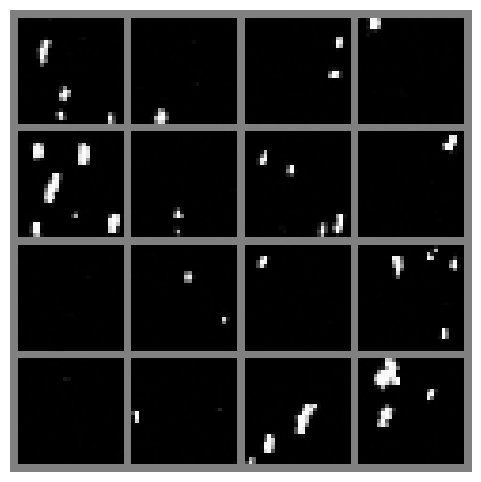

In [18]:
def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

samples = best_model.to(device).sample([16,1,28,28])
show_imgs(samples.cpu())